In [1]:
import os, json
import pandas as pd
import json 
import plotly.express as px
from IPython.display import Image

import regex as re
re.DEFAULT_VERSION = re.VERSION1

import gc
import string
import time
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from gensim.models.callbacks import CallbackAny2Vec
from polyleven import levenshtein
import spacy

import pickle

In [ ]:
#TO REMOVE ARTICLE CONTAINING : 
{['RENSEIGNEMENT','MONDAIN'], ['TEMPERATURE','TEMPÉRATURE'], 
 ['JOURNEE'], ['MARIAGES'], ['DEUIL'], ['LA BOURSE'], ['THÉÂTRE','SPECTACLE','OPERA','OPÉRA','THEATRE','COURRIER'],
 ['SOMMAIRE']}


#split par sequence de majuscule :
#findall occurence, remove ceux qui sont juste des chiffres romain 
#avec potentiellement de la ponctuation : XXXVI XVI, XVIII. IV' 
# replace les autres avec un marqueurs pour le spliting
headlineRegex = '\p{Lu}(?:.?\p{Lu}.?){2,}\p{Lu}{2}\W*(?=\s\p{Lu}?[^\p{Lu}]{,2}\p{Ll})'
headlineCompiled = regex.compile(headlineRegex)

#remove les sequences noisy : regex pour séquence de mot de 1 ou 2 caractere entrecoupé de 

#split comment avant + sequence de Majuscule qui ne sont pas des chiffres romains et numeroté tous les paragraphs garder (avec ratio >0.6 par eg) 
#pour chaque page (0 -n paragraphe dans la page x)

#checker chiffre romain : extraire potentiel chiffre romain [MXCVID] et verifier avec regex:
romanRegex = '(?=[MDCLXVI])M{0,3}(?:C[DM]|DC{0,3}|C{1,3})?(?:X[LC]|LX{0,3}|X{1,3})?(?:I[XV]|VI{0,3}|I{1,3})?'

#regarder distriution des logueurs de text après split par headlines

# on garde TOUS LES TEXTES, sauf les trop noisy, pour train word2vec, les bigrams et le correcteur

# on vire les articles avec les mots clefs par dessus en majuscule et les dernières pages

# on clean avec le corrector

# on revire les articles avec les mots clefs par dessus en majuscule (o k ou)

# on finalClean

# on rerevire les articles avec les mots clefs par dessus en majuscule (o k ou)? 

#Faire un graph de la difference de la moyenne de char par année avant et après correction



# Data Cleaning 

In [30]:

# Class for cleaning such that the regex don't have to be compiled each time
class TextCleaner:
    def __init__(self):
        
        essentialNonAlpha = re.escape("!',-.:;?\n")
        self.vowel = '[aeiouAEIOU]'
        self.consonnant = '[\p{L}&&[^aeiouAEIOU]]'
        #regex to keep only some essential punctation and alphanumeric character
        self.noisyChar = re.compile(f'[^\w{essentialNonAlpha}]+')
        
        #regex to remove sequence of random character 
        self.noisySequence = re.compile('(?<=\W)\W*(?:(?:.{1,2}|'+
                                        self.consonnant + '{2,}|' + 
                                        self.vowel + '{2,})' + 
                                        '\W+){4,}.{1,2}\s')
        self.noisyPunctSequence = re.compile(f'(?<=[{essentialNonAlpha}\$])\W+')
        
        #regex for misplaced punctuation character
        self.stickingPunct = re.compile('(?:(?<=[\!\?\.])(?=\p{Lu}))')
        self.noisyStickingPunct = re.compile('[\!\?\.][^\p{L}]*(?=\p{Ll})')
        
        #Regex for splitting text into "articles"
        self.splitPatterns = re.compile('(?:(?<=[!?.])[^\p{Ll}]*\n|'+
                                        '\n\W*(?=\p{Lu})|'+
                                        '(?:\n?_DUMP_\n?)+)')
        
        # regex for headlines detection                              
        headlineRegex = '\p{Lu}(?:\.?\p{Lu}\.?)*\p{Lu}.{0,3}(?:\.?\p{Lu}\.?)*\p{Lu}{2}[^\p{Ll}]*(?=\p{Ll}{4,})'
        self.headlineCompiled = re.compile(headlineRegex)
        
        # regex for roman number verification
        romanRegex = ('(?=[MDCLXVI])M{0,3}(?:C[DM]|DC{0,3}|C{1,3})?'+
                          '(?:X[LC]|LX{0,3}|X{1,3})?(?:I[XV]|VI{0,3}|I{1,3})?')

        self.romanCompiled = re.compile(romanRegex)
        
        
    def filterPage(self, pages):
        if len(pages) == 4 :
            return [(page,content) for page,content in enumerate(pages[:-1])]
        elif (len(pages) == 6) or (len(pages) == 8):
            return [(page,content) for page,content in enumerate(pages[:-2])]
        else : 
            return []
    
    def getOCRconfidence(self, confidence):
        return float(confidence[0].split()[-1].replace(',','.'))

    def getAlphaRatio(self, text):
        return sum([(c.isalpha() and c.islower()) or (c == ' ') for c in text])/len(text)
        
       
    def isRomanNumber(self, headline):
        romanNumberLetter = ' '.join(re.findall('[LXIVCDM]{2,}',headline.upper()))
        headlineWoPunct = ' '.join(re.findall('\w{2,}',headline))
        if len(romanNumberLetter)/len(headlineWoPunct)>0.7:
            match = self.romanCompiled.fullmatch(romanNumberLetter)
            return False if (match is None) else True
        else:
            return True
                                        
    def splitParagraphs(self, page):
        headlines = self.headlineCompiled.findall(page)
        headlines = [headline for headline in headlines if not self.isRomanNumber(headline)]
        for headline in headlines:
            splitted = page.replace(headline, '__SPLIT__'+headline)
        page = page.replace('\n','__SPLIT__')
        paragraphs = [(n,paragraph,self.getAlphaRatio(paragraph)) for n,paragraph 
                      in enumerate(page.split('__SPLIT__')) if len(paragraph)>0]
        
        return paragraphs
        
        
    def cleanParagraph(self, text):
        textLen = len(text)
        text = ' '+' '.join(self.noisyChar.sub(' ', text).split()) + ' '
        
        # transform "..." sequence to "$" to preserve from next steps
        text = re.sub('(?<=[\w\s])\.{3}\s','$ ',text)
        
        text = self.noisySequence.sub(' ',text)
        text = self.noisyPunctSequence.sub(' ',text)
        
        ### get "..." back
        text = text.replace('$ ','... ')
        text = ' '.join(text.split())
        ratio = len(text)/textLen
        return text if (ratio>0.5) else '_DUMP_'
            
    def filterParagraphs(self,paragraphs): 
        keepCondition = lambda ratio, content : (ratio>0.75) and (len(content)>5)
        paragraphs = [(ID, self.cleanParagraph(paragraph)) if keepCondition(ratio,paragraph) 
                      else (-1, '_DUMP_')
                      for ID, paragraph, ratio in paragraphs]
        articles = []
        article = ''#paragraphs[0][1]
        articleID = ''#str(paragraphs[0][0])
        skip = True
        for ID, art in paragraphs:
            if art == '_DUMP_':
                skip = True
                if (len(article)>0) and (len(articleID)>0):
                    articles.append((articleID, article))
                    article = ''
                    articleID = ''
            elif skip:
                skip = False
                article = art
                articleID = str(ID)
            else:
                isArticle = article+'\n' +art
                isArticle = self.splitPatterns.split(isArticle)
                if len(isArticle)==1:
                    article = isArticle[0].replace('\n',' ')
                    articleID += '-' +str(ID)
                    
                elif (len(article)>0) and (len(articleID)>0):
                    articles.append((articleID, article))
                    article = art
                    articleID = str(ID)
                    
        if (len(article)>0) and (len(articleID)>0): 
            articles.append((articleID, article))
        
        return articles
    
    

## Loading the json files

In [31]:
text = []
for root, dirs, files in os.walk('data/le_figaro'):
    for name in files:
        if name.endswith((".json")) and 'le_figaro' not in name:
            with open(os.path.join(root, name)) as f: 
                text.append(json.load(f))

In [32]:
t = time.time()
textDf = pd.DataFrame(text)
textCleaner = TextCleaner()
gc.collect()
textDf['date'] = textDf.date.apply(lambda x : x[0]) 
textDf['year'] = textDf.date.apply(lambda x : x.split('-')[0]) 
textDf['OCR confidence'] = textDf['format'].apply(textCleaner.getOCRconfidence)
textDf['nPages'] = textDf.contentAsText.apply(len)
textDf = textDf[['contentAsText','date','OCR confidence','nPages']].rename(columns = {'contentAsText':'pages'})
del text
gc.collect()
print(time.time()-t)

0.5656149387359619


## Visualization of number of page by issue

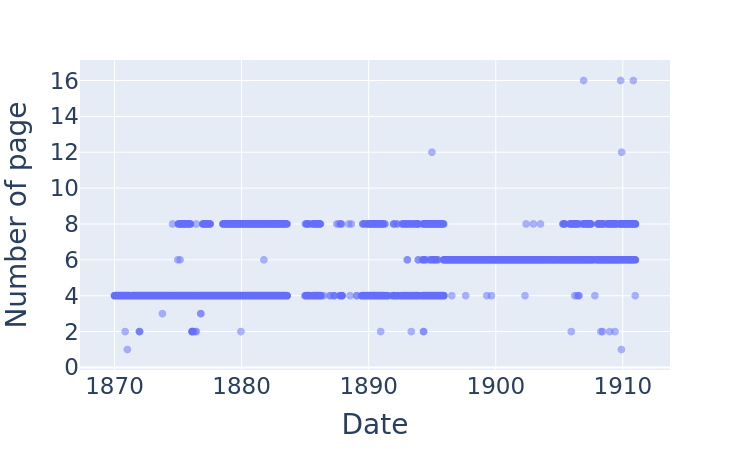

In [33]:
img = px.scatter(textDf, x = 'date', y = 'nPages')
img.update_traces(marker={'size': 8,'opacity' :0.5})
img.update_layout(
    #title="Plot Title",
    xaxis_title="Date",
    yaxis_title="Number of page",
    font_size = 23
    #legend_title="Legend Title",
)
Image(img.to_image(format="png", width=750, height=450))

## Split issues by pages

In [34]:
t = time.time()
textCleaner = TextCleaner()
textDf = textDf.drop(columns = 'nPages').copy()
textDf.pages = textDf.pages.apply(lambda pages : [(n,page) for n,page in enumerate(pages)])
textDf = textDf[textDf.pages.apply(len)>0].explode('pages').reset_index().drop(columns ='index')
textDf = textDf[textDf.pages.apply(len)>0]
textDf['pageNum'] = textDf['pages'].apply(lambda page_content : page_content[0])
textDf['pages'] = textDf['pages'].apply(lambda page_content : page_content[1])
textDf = textDf[textDf.pages.apply(len)>0]
textDf['content'] = textDf.pages.apply(textCleaner.splitParagraphs)
print(t - time.time())

-478.63573932647705


## Plot noise density

In [ ]:
le_figaro_paragraph = textDf.drop(columns = ['pages']).copy().explode('content')
le_figaro_paragraph = le_figaro_paragraph[~le_figaro_paragraph.content.isna()]
(le_figaro_paragraph['paragraphNum'], 
 le_figaro_paragraph['content'],
 le_figaro_paragraph['alphaRatio']) = zip(*le_figaro_paragraph.content)
le_figaro_paragraph.to_csv('data/le_figaro_paragraph.csv',index=False)


In [ ]:
def label(x):
    if x <10 :
        return '5<length<10'
    if x <25 :
        return '10<=length<25'
    if x <50 :
        return '25<=length<50'
    elif x <100: 
        return '50<=length<100'
    elif x <500:
        return '100<=length<500'
    elif x <1000:
        return '500<=length<1000'
    else:
        return '1000<=length'

le_figaro_paragraph['len'] = le_figaro_paragraph['content'].apply(len)
le_figaro_paragraph['lenLabel'] = le_figaro_paragraph['len'].apply(label)

In [ ]:
img = px.histogram(le_figaro_paragraph[(le_figaro_paragraph['len'] > 5)].sort_values('len'), x = 'alphaRatio', color='lenLabel', nbins = 20)
img.update_layout(
    #title="Plot Title",
    xaxis_title="Ratio of lower alphabetic and space character<br>over the total length of the paragraph",
    yaxis_title="Number of article",
    font_size = 23,
    legend_title="Length of articles",
)
Image(img.to_image(format="png", width=1000, height=450))

## Remove noisy part of the corpus and clean text by removing unwanted character introduced by OCR

In [ ]:
t = time.time()
textDf.content = textDf.content.apply(textCleaner.filterParagraphs)
textDf = textDf.explode('content')
textDf = textDf[~textDf.content.isna()]
textDf['contentID'], textDf['content'] = zip(*textDf.content)
textDf = textDf[~textDf.content.isna()].reset_index().drop(columns='index')
textDf = textDf[textDf.content.apply(len)>25]
print(t - time.time())

In [ ]:
textDf[textDf.content.apply(len)<25]

In [ ]:
textDf.to_csv('data/le_figaro_prefiltered.csv',index=False)

# Word2vec model for recurrent OCR error correction

## Training the model

In [ ]:
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0
        self.losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        self.losses.append(loss if (self.epoch == 0) else loss-self.loss_previous_step)
        print('Loss after epoch {}: {}'.format(self.epoch, self.losses[-1]))
        self.epoch += 1
        self.loss_previous_step = loss
        if (self.epoch)%5 ==0:
            print('saving model')
            model.save(f"models/embeddings/wvstep/Word2Vec_OCR_correction_step{self.epoch}.model")

In [4]:
textDf = pd.read_csv('data/le_figaro_prefiltered.csv')

In [ ]:
t = time.time()
textDf['raw_article'] = textDf.content.str.replace('[\!,\.:;\?](?=\W)',' . ',regex=True)
textDf['raw_article'] = textDf.raw_article.str.replace('[\!,\.:;\?](?=\p{L})','',regex=True)
textDf['raw_article'] = (' '+textDf.raw_article+' ').str.replace('[^\w](?:.?\d)+[^\w]',' ',regex=True)
textDf = textDf[textDf['raw_article'].apply(len)>25]
raw_articles = textDf['raw_article'].str.split().tolist()
bigram = Phrases(raw_articles, min_count=3, threshold=7.5)
bigram_mod = Phraser(bigram)
raw_articles = list(bigram_mod[raw_articles])
print(time.time()-t)
print(len(textDf))

In [ ]:
textDf['nGram'] = raw_articles
textDf['nGram'] = textDf['nGram'].apply(' '.join)
textDf.to_csv('data/le_figaro_prefiltered.csv',index=False)

In [ ]:
corLexique = textDf.raw_article.str.split().explode().value_counts()
corLexique = corLexique[corLexique>25]
corLexique = corLexique.to_dict()

errLexique = textDf.nGram.str.split().explode().value_counts()
errLexique = errLexique[errLexique>4]
errLexique = errLexique.to_dict()

In [2]:
#textDf = pd.read_csv('data/le_figaro_prefiltered.csv')
#raw_articles = textDf.nGram.str.split().tolist()

In [ ]:
cb = callback()
model = Word2Vec(sentences  = raw_articles,
                 vector_size = 128,
                 window = 6,
                 min_count = 5,
                 sample = 1e-4,
                 sg = 1,
                 negative = 10,
                 ns_exponent=0.25,
                 epochs = 15,
                 workers = 30,
                 callbacks = [cb],
                 compute_loss = True)
model.save("models/embeddings/Word2Vec_OCR_correction.model")

## Make the error-correction pair 

In [ ]:
class Corrector():
    
    def __init__(self,model=False,corLexique=None,errLexique=None):
        self.model = model
        if  corLexique and errLexique:
            self.corLexique = corLexique
            self.errLexique = errLexique
            self.typosPair = {}
            self.segmentationsPair = {}
            self.fusionsPair = {}
        else:
            self.loadData()
        
        self.typoRatio = 15
        self.segRatio = 15
        self.lineBreakPattern = re.compile('[^\p{L}]?\-[^\p{L}]?')
        self.toSegmentAgain = None
        
    
    
    def makeCorrectionPair(self, word, wordFreq):
        typos = []
        segmentations = []
        fusions = []
        wordLen = len(word)
        errWordFreq = self.errLexique.get(word,False) # for fusion
        if (wordLen>1) and errWordFreq:
            for simWord, sim in self.model.wv.most_similar(word,topn = 50):
                
                simWordLen = len(simWord)
                diffLen = simWordLen-wordLen
                simWordFreq = self.errLexique.get(simWord,False)
                if (abs(diffLen) in [0,1,2]) and simWordFreq:
                    simWordFreq = max(self.corLexique.get(simWord,0), simWordFreq)
                    if ((wordLen>2) and  (abs(diffLen) in [0,1]) and (sim>0.60) and 
                        (simWordFreq*self.typoRatio<wordFreq)):
                        if not ((word[-1] in '!.?,:;') or (word[1:].lower() == simWord[1:].lower())):
                            dist = levenshtein(word, simWord, 2)
                            if (diffLen == 0) and (dist == 1):
                                typos.append((simWord.replace('_',' '),sim))
                            elif ((simWordLen>5) and (dist==2) and 
                                  (simWordFreq*self.typoRatio*4<wordFreq) and 
                                   not (word[1:-2].lower() in simWord[1:].lower())):
                                typos.append((simWord.replace('_',' '),sim))
                    if (simWordFreq*max(self.segRatio/simWordLen,2)<wordFreq) and (diffLen>0):
                        if simWord.replace('_','') == word: 
                            segmentations.append((simWord,sim))
                        elif  self.lineBreakPattern.sub('',simWord) == word.replace('-',''):
                            segmentations.append((simWord,sim)) 
                        elif  (simWordFreq*self.segRatio*4/simWordLen<wordFreq) and (simWord.replace('\'','') == word):
                            segmentations.append((simWord,sim))
                            
                    elif (errWordFreq*self.segRatio<simWordFreq) and (diffLen>=0): 
                        if (re.sub('[\'\-_]','',simWord) == word) and (diffLen>0):
                            fusions.append((word,sim))
                            word = simWord.replace('_',' ')
                            break
                        # gerer les ' dans les mots : "il'y"
                        elif (word.replace('\'',' ') == simWord.replace('_',' ')) and (word != simWord) :
                            fusions.append((word,sim))
                            word = simWord.replace('_',' ')
                            break
                        
                        
        return word, typos, segmentations, fusions
    
    
    def append(self, word, typos, segmentations, fusions):
        if typos:
            self.typosPair[word]=typos
            
        if segmentations:
            self.segmentationsPair[word]=segmentations
            
        if fusions:
            self.fusionsPair[word]=fusions
        
        
    def getErrors(self):
        getTriple = lambda d : [(correct,error,sim,self.errLexique.get(error,0)) for correct 
                                in d for error,sim in d[correct]]
        
        typoDf = pd.DataFrame(getTriple(self.typosPair),
                              columns=['correct','error','sim','errCount'])
        segDf = pd.DataFrame(getTriple(self.segmentationsPair),
                             columns=['correct','error','sim','errCount'])
        fusDf = pd.DataFrame(getTriple(self.fusionsPair),
                             columns=['correct','error','sim','errCount'])
        return typoDf,segDf, fusDf
                        
        
    def saveData(self):
        
        self.model.save("models/embeddings/Word2Vec_OCR_correction.model")
        with open('data/lexiques.json','w') as file : 
            json.dump((self.corLexique, self.errLexique), file)
        with open('data/correctionPairs.json','w') as file : 
            json.dump((self.typosPair,self.segmentationsPair,self.fusionsPair), file)
        
        
    def loadData(self):
        if (self.model is None):
            self.model = Word2Vec.load("models/embeddings/Word2Vec_OCR_correction.model")
        with open('data/lexiques.json','r') as file : 
            self.corLexique,self.errLexique = json.load(file)
        with open('data/correctionPairs.json','r') as file :
            self.typosPair,self.segmentationsPair, self.fusionsPair= json.load(file)
        print('Lexique of correct word size: {}'.format(len(self.corLexique)))    
        print('Lexique of error word size: {}'.format(len(self.errLexique)))
        nTypoPair = len([pair for k in self.typosPair for pair in self.typosPair[k]])
        nSegPair = len([pair for k in self.segmentationsPair for pair in self.segmentationsPair[k]])
        nFusPair = len([pair for k in self.fusionsPair for pair in self.fusionsPair[k]])
        print('Number of correct/error for typo  : {}'.format(nTypoPair))
        print('Number of correct/error for segmentation  : {}'.format(nSegPair))
        print('Number of correct/error for fusion  : {}'.format(nFusPair))
        
    def setCorrectors(self):
        nlp = spacy.load('fr_core_news_lg',exclude=['lemmatizer',"parser", "tagger","ner","tok2vec"])
        lemmatizer = nlp.add_pipe("lemmatizer", config={"mode": "lookup"})
        lemmatizer.initialize()
        getLemma = lambda w : lemmatizer.lookups.get_table('lemma_lookup').get(lemmatizer.vocab.strings[w],w)
        
        self.typoDf, self.segDf, self.fusDf = self.getErrors()
        lenTypo = len(self.typoDf)
        self.typoDf = self.typoDf[self.typoDf.error.apply(getLemma) != self.typoDf.correct.apply(getLemma)]
        
        print('{} typo dropped because sharing lemmas'.format(lenTypo-len(self.typoDf)))
        lenTypo = len(self.typoDf)
        self.typoDf = self.typoDf.sort_values('sim',ascending=False).drop_duplicates(['error'])
        typos = self.typoDf.set_index('error').to_dict(orient = 'index')
        redirect = lambda correct : (correct in typos and   
                                     self.corLexique.get(typos[correct]['correct'],0)>self.corLexique.get(correct,0))
        redirectTypos = lambda correct : typos[correct]['correct'] if redirect(correct) else correct
                                          
        self.typoDf.correct = self.typoDf.correct.apply(redirectTypos)
        
        
        self.typoDf['errCompiled'] = ('(?<=[^\p{L}])'+
                                      self.typoDf['error']+
                                      '(?=[^\p{L}])').apply(re.compile)
        self.fusDf['errCompiled'] = ('(?<=[^\p{L}])'+
                                      self.fusDf['error']+
                                      '(?=[^\p{L}])').apply(re.compile)

        self.segDf['errCompiled'] = ('(?<=[^\p{L}])'+
                                     self.segDf['error'].replace('(?<=[\w\'][_\-])[_\-]?(?=[\w\'])','[ \-]?', regex=True)+
                                     '(?=e?s?[^\p{L}F])').apply(re.compile)
        
        self.typoDf = self.typoDf.sort_values('sim',ascending=False).drop_duplicates(['errCompiled'])
        print('{} typo duplicates dropped.\n{} error-correct pairs\n'.format(lenTypo-len(self.typoDf),
              len(self.typoDf)))
        
        lenFus = len(self.fusDf)
        self.fusDf = self.fusDf.sort_values('sim',ascending=False).drop_duplicates(['errCompiled'])
        print('{} fusion duplicates dropped.\n{} error-correct pairs\n'.format(lenFus-len(self.fusDf),
              len(self.fusDf)))
        
        lenSeg = len(self.segDf)
        self.segDf = self.segDf.sort_values('sim',ascending=False).drop_duplicates(['errCompiled'])
        print('{} segmentation duplicates dropped.\n{} error-correct pairs\n'.format(lenSeg-len(self.segDf),
              len(self.segDf)))
        
        print('{} error-correct pairs in total'.format(len(self.typoDf)+len(self.fusDf)+len(self.segDf)))
        
        self.segDf['error'] = self.segDf['error'].str.split('[_\-]+',regex=True).apply(lambda l : [w for w in l if w])
        
        self.typoDict = self.typoDf.drop(columns = ['sim','errCount']).set_index('errCompiled').to_dict(orient = 'index')
        self.segDict = self.segDf.drop(columns = ['sim','errCount']).set_index('errCompiled').to_dict(orient = 'index')
        self.fusDict = self.fusDf.drop(columns = ['sim','errCount']).set_index('errCompiled').to_dict(orient = 'index')
        
    def applyCorrection(self,index,text):
        nSub = 0
        text = ' ' + text + ' '
        for errCompiled,row in self.segDict.items():
            if all(w in text for w in row['error']):
                text,n = errCompiled.subn(row['correct'],text)
                nSub+=n
        for errCompiled,row in self.fusDict.items():
            if row['error'] in text:
                text,n = errCompiled.subn(row['correct'],text)
                nSub+=n
        for errCompiled,row in self.typoDict.items():
            if row['error'] in text:
                text,n = errCompiled.subn(row['correct'],text)
                nSub+=n
        return index, ' '.join(text.split()),nSub
    
    
    def setToSegment(self, wordCountDict):
        self.toSegment = [(w,count)                                     
                          for w,count in wordCountDict.items() 
                          if '-' in w and (count < 100)]
        checkCount = lambda w,count : all((wordCountDict.get(s,0)>=count*10) for s in w.split('-')) and (count<50)
        getAlternative = lambda w,count : (w.replace('-',' ')
                                           if (count*15<wordCountDict.get(w.replace('-',''),0)) 
                                           else w)
        makeRep = lambda w,count : w.replace('-',' ') if checkCount(w,count) else getAlternative(w,count)
        
        self.toSegment = [(w,
                           re.compile('(?<=[^\p{L}])'+w+'(?=e?s?[^\p{L}])'), 
                           makeRep(w,count)) 
                          for w,count in self.toSegment 
                          if '-' in w and (count < 100)]
    
    def finalSegmentation(self, text):
        nSub = 0
        text = ' ' + text + ' '
        for w, reW, wRep in self.toSegment:
            if w in text:
                text,n = reW.subn(wRep,text)
                nSub+=n
        return ' '.join(text.split()),nSub
                        
                    
        

In [ ]:
corrector = Corrector(model,corLexique,errLexique)

In [ ]:
words = [w for w,_ in corrector.corLexique.items()]
freqs = [f for _,f in corrector.corLexique.items()]
gc.collect()
with tqdm(total=len(words),mininterval = 2, miniters =500) as pbar:
    with ProcessPoolExecutor(max_workers=5) as executor:
        for word, typos, segmentations, fusions in executor.map(corrector.makeCorrectionPair, 
                                                                words, freqs, chunksize=2000):
            corrector.append(word, typos, segmentations, fusions)
            pbar.update(1)
corrector.saveData()

In [81]:
corrector.setCorrectors()

287 typo dropped because sharing lemmas
0 typo duplicates dropped.
17361 error-correct pairs
0 fusion duplicates dropped.
118 error-correct pairs
5547 segmentation duplicates dropped.
68703 error-correct pairs
86182 error-correct pairs in total


In [ ]:
corrector.setCorrectors()

In [82]:
a,b,c = corrector.getErrors()

In [95]:
a[a.error == 'contré']#.sort_values('errCount', ascending = False).head(50)

,correct,error,sim,errCount
426,contre,contré,0.90904,1801


In [22]:
corrector.setCorrectors()

In [87]:
for i in range(5):
    t = time.time()

    i, test, n = corrector.applyCorrection(i, textDf.iloc[i].content)
    print(time.time()-t)
    print(n,test)

2.9005935192108154
76 La Roche, octobre. Tandis que Silène, escorté de bacchan tes, de faunes, de prêtres dionysiaques, répandait pour vous, Parisiens, du haut de son char, les grappes de raisin bleu, de raisin: blanc, de raisin rouge, nous, dans nos contrees du Sud-Ouest si longtemps indigentes et veuves de récolte, nous acclamions pour la première fois'depuis des années une grande, une belle vendange. Eh sans doute, dans les temps passés, avant que la bête eût tout ravagé, les anciens du pays se rappellent en avoir vu d'égales. Mais celle-ci semble plus précieuse, parce qu'elle fut, cent fois plus que naguère, difficile a arracher au sol ingrat. L'histoire de la vigne en Gascogne, dans les trente dernières f années, peut profiter à tous ceux qui la veulent bien entendre, fussent-ils ignorants d'agriculture et buveurs de bière ou d'eau. Car ce peuple gascon, réputé surtout pour son goût de l'aventure, sa hâblerie insouciante, offre ici à la fois une leçon d'énergie et un gage d'espoir

0.2678048610687256
14 La Température Malgré la hausse relative du baromètre 766 IU, n dans la matinée, la journée d'hier a été triste, humide et surtout nuageuse à Paris. Dans le nord et le centre de l'Europe, ainsi que vers le pas de Calais de fortes pluies sont signalées, de même qu'à Dunkerque, Cherbourg et Nice. Cependant la mer est généralement belle sur nos côtes. Quant à la température, elle s'abaisse un peu partout; à Paris le thermomètre marquait o à sept heures du matin, à quatre heures de l'après-midi ; on notait 6 à Bordeaux et 31 à Alger, au-dessous au pic du Midi. Attendons-nous à un temps beau et frais. Dans la soirée, le baromètre restait à 768mm vers minuit. À Travers Paris Hier, pendant que le roi des Hellènes, en l'honneur duquel une très belle fête a été: donnée le soir à l'Elysée, visitait l'Exposition, le Président de la République montait de son côté en voiture avec son fils, M. Paul Loubet, et M. Abel Combàrieu, directeur de son cabinet civil, et se rendait au c

In [90]:
print(0,textDf.iloc[0].content)

0 La Roche, octobre. Tandis que Silène, escorté de bacchan tes, de faunes, de prêtres dionysiaques, répandait pour vous, Parisiens, du haut de son char, les grappes de raisin bleu, de raisin: blanc, de raisin rouge, nous, dans nos contrées du Sud-Ouest si longtemps indigentes et veuves de ré colte, nous acclamions pour la première fois'depuis des années une grande, une belle vendange. Eh sans doute, dans les temps passés, avant que la bête eût tout ravagé, les anciens du pays se rap pellent en avoir vu d'égales. Mais celle-ci semble plus précieuse, parce qu'elle fut, cent fois plus que naguère, difficile a arracher au sol ingrat. L'histoire de la vigne en Gascogne, dans les trente dernières f années, peut profiter à tous ceux qui la veulent bien entendre, fussent-ils ignorants d'agri culture et buveurs de bière ou d'eau. Car ce peuple gascon, réputé surtout pour son goût de l'aventure, sa hâblerie in souciante, offre ici à la fois une leçon d'énergie et un gage d'espoir national.. Quel

## Apply the corrections

In [105]:
totalSub = 0
texts = [(ind,row['content']) for ind,row in textDf.iterrows()]
index = [ind for ind,_ in texts]
texts = [text for _,text in texts]
textsCorrected = {}
corrector.setCorrectors()
with tqdm(total=len(texts),mininterval = 2, miniters =100) as pbar:
    with ProcessPoolExecutor(max_workers=30) as executor:
        for indice, corrected, n in executor.map(corrector.applyCorrection, index, texts, chunksize=100):
            textsCorrected[indice] = corrected
            totalSub+=n
            pbar.update(1)
        

    
textDf['corrected'] = pd.Series(textDf.index).apply(textsCorrected)

287 typo dropped because sharing lemmas
661 typo duplicates dropped.
17361 error-correct pairs

0 fusion duplicates dropped.
118 error-correct pairs

5547 segmentation duplicates dropped.
68703 error-correct pairs

86182 error-correct pairs in total


338001it [2:05:06, 73.15it/s]                                                   Process ForkProcess-118:
Process ForkProcess-138:
Traceback (most recent call last):
  File "/opt/anaconda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/anaconda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda/lib/python3.9/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
  File "/opt/anaconda/lib/python3.9/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
  File "/opt/anaconda/lib/python3.9/multiprocessing/queu

KeyboardInterrupt: 

  File "/opt/anaconda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda/lib/python3.9/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
  File "/opt/anaconda/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/opt/anaconda/lib/python3.9/re.py", line 289, in _compile
    def _compile(pattern, flags):
KeyboardInterrupt
Process ForkProcess-128:
Traceback (most recent call last):
  File "/opt/anaconda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda/lib/python3.9/concurrent/futures/process.py", line 240, in _process_worker
  

In [ ]:
textDf.to_csv('data/le_figaro.csv',index=False)

In [ ]:
wordCount = textDf['corrected'].str.split().value_counts()
with open('data/countCorrected.txt','w') as file:
    file.write("corrected : {}, ratio : {}".format(totalSub,totalSub/wordCount.sum()))

corrector.setToSegment(wordCount.to_dict())
textDf['correctedFinal'] = textDf['corrected'].apply(corrected.finalSegmentation)
totalSub+= textDf['correctedFinal'].apply(lambda pair : pair[1]).sum()
textDf['correctedFinal']= textDf['correctedFinal'].apply(lambda pair : pair[0]).sum()
with open('data/countFinalCorrected.txt','w') as file:
    file.write("corrected : {}, ratio : {}".format(totalSub,totalSub/wordCount.sum()))
textDf.to_csv('data/le_figaro.csv',index=False)

In [101]:
totalSub

0